In [1]:
import pennylane_qiskit
import pennylane as qml
from pennylane import numpy as np
import keras.datasets.mnist
import matplotlib.pyplot as plt
from matplotlib import *
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

https://pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/

https://keras.io/examples/vision/siamese_contrastive/

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]**2)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]**2)

In [4]:
pca_train = PCA(n_components=50).fit_transform(x_train)
embd_train = TSNE(n_components = 2, random_state=0).fit_transform(pca_train)

C:\Users\KD\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\KD\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [5]:
pca_test = PCA(n_components=50).fit_transform(x_test)
embd_test = TSNE(n_components = 2, random_state=0).fit_transform(pca_test)

C:\Users\KD\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\KD\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [6]:
embd_min_train = np.min(embd_train, axis=0)
embd_max_train = np.max(embd_train, axis=0)
embd_train = (2*(embd_train - embd_min_train) / (embd_max_train - embd_min_train))-1

In [7]:
embd_min_test = np.min(embd_test, axis=0)
embd_max_test = np.max(embd_test, axis=0)
embd_test = (2*(embd_test - embd_min_test) / (embd_max_test - embd_min_test))-1

In [8]:
n = 10000
x_train, x_val, y_train, y_val = train_test_split(embd_train[:n], y_train[:n], train_size=0.8, shuffle = True)

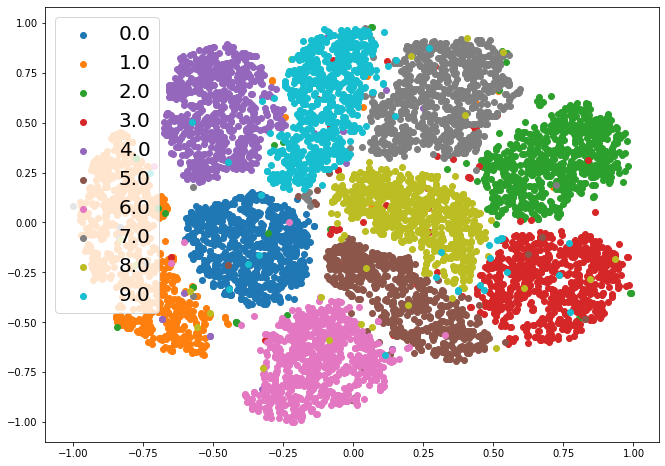

In [9]:
plt.figure(figsize=(11, 8))
for i in range(np.max(y_train) + 1):
    data = x_train[np.where(y_train == i)]
    plt.scatter(data[:,0], data[:,1], label = float(i))
plt.legend(fontsize = 20)
plt.show()

In [10]:
# Code from - https://keras.io/examples/vision/siamese_contrastive/
def make_pairs(x, y):

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = np.random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = np.random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = np.random.randint(0, num_classes - 1)

        idx2 = np.random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


In [11]:
pairs_train, labels_train = make_pairs(x_train, y_train)

In [12]:
pairs_val, labels_val = make_pairs(x_val, y_val)

In [13]:
x_train_1 = pairs_train[:, 0] 
x_train_2 = pairs_train[:, 1]

In [14]:
x_val_1 = pairs_val[:, 0] 
x_val_2 = pairs_val[:, 1]

In [15]:
tf.keras.backend.set_floatx('float64')

In [16]:
n_qubits = 2
block_net = 2
block_concat = 2
dev_net = qml.device("default.qubit.tf", wires=n_qubits)
dev_concat = qml.device("default.qubit.tf", wires=n_qubits*2)

In [17]:
@qml.qnode(dev_net, interface="tf", diff_method="backprop")
def qnode_net(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    for i in range(block_net):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights[i], wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

@qml.qnode(dev_concat, interface="tf", diff_method="backprop")
def qnode_concat(inputs, weights):
    for i in range(block_concat):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits*2))
        qml.templates.StronglyEntanglingLayers(weights[i], wires=range(n_qubits*2))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits*2)]

In [18]:
layer_net = 2
weight_shapes_net = {"weights": (block_net, layer_net, n_qubits, 3)}
qlayer_net = qml.qnn.KerasLayer(qnode_net, weight_shapes_net, output_dim=n_qubits)

In [19]:
layer_concat = 2
weight_shapes_concat = {"weights": (block_concat, layer_concat, n_qubits*2, 3)}
qlayer_concat = qml.qnn.KerasLayer(qnode_concat, weight_shapes_concat, output_dim=n_qubits*2)

In [20]:
n_components = 2 
input_data = tf.keras.Input(shape=(n_components,))
x = qlayer_net(input_data)
embed_net = tf.keras.Model(inputs = input_data, outputs = x)

In [21]:
input1 = layers.Input(n_components,)
input2 = layers.Input(n_components,)

VQC_1 = embed_net(input1)
VQC_2 = embed_net(input2)

merge = layers.Concatenate()([VQC_1, VQC_2])
merge_VQC = qlayer_concat(merge)

output = layers.Dense(1, activation = "sigmoid")(merge_VQC)
siamese_net = tf.keras.Model(inputs = [input1, input2], outputs = output)

In [22]:
margin =1 
def contrastive_loss(y_true, y_pred):
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
siamese_net.compile(loss=contrastive_loss, optimizer=opt, 
                    metrics=["accuracy"], run_eagerly=True)

In [24]:
fitting = siamese_net.fit([x_train_1, x_train_2], labels_train, 
                    validation_data = ([x_val_1, x_val_2], labels_val)
                    ,epochs=5, batch_size=100, verbose=1)

Epoch 1/5
160/160 [==============================] - 4148s 26s/step - loss: 0.2102 - accuracy: 0.6806 - val_loss: 0.1570 - val_accuracy: 0.7905
Epoch 2/5
160/160 [==============================] - 5696s 36s/step - loss: 0.1406 - accuracy: 0.8139 - val_loss: 0.1284 - val_accuracy: 0.8440
Epoch 3/5
160/160 [==============================] - 4950s 31s/step - loss: 0.1218 - accuracy: 0.8416 - val_loss: 0.1160 - val_accuracy: 0.8508
Epoch 4/5
160/160 [==============================] - 3621s 23s/step - loss: 0.1146 - accuracy: 0.8541 - val_loss: 0.1105 - val_accuracy: 0.8590
Epoch 5/5
160/160 [==============================] - 5367s 34s/step - loss: 0.1109 - accuracy: 0.8593 - val_loss: 0.1098 - val_accuracy: 0.8552


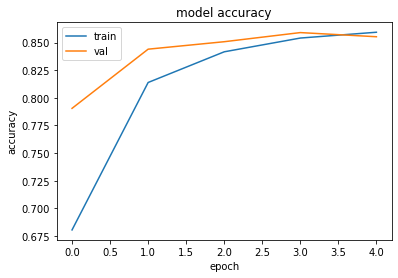

In [25]:
plt.plot(fitting.history['accuracy'])
plt.plot(fitting.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

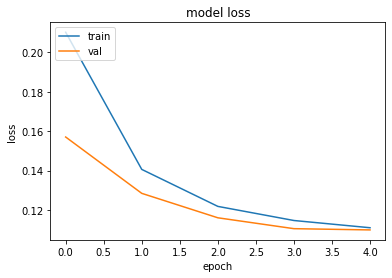

In [26]:
plt.plot(fitting.history['loss'])
plt.plot(fitting.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
pairs_test, labels_test = make_pairs(embd_test, y_test)

In [28]:
x_test_1 = pairs_test[:, 0] 
x_test_2 = pairs_test[:, 1]

In [29]:
from sklearn.metrics import accuracy_score
prediction = siamese_net.predict([x_test_1, x_test_2])

In [30]:
labels_test = labels_test.reshape(labels_test.shape[0], 1)

In [31]:
round(accuracy_score(np.round(prediction), labels_test),3)

0.823